In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
import tensorflow as tf
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb
from IPython import display
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import normalize
from skimage.color import rgb2lab, lab2rgb, hsv2rgb

In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    os.chdir('drive/MyDrive/Python_Projects/Landscape_Generation')
    os.listdir()

['images.zip',
 'thumbs.zip',
 'images',
 'thumbs',
 'logs',
 '1.jpeg.JPG',
 'generator_1',
 'model.png']

In [ ]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

def load_image(image_file):
    # Read and decode an image file to a uint8 tensor

    image = image * 2 - 1
    return image

def load_thumb(image_file):
    image = load(image_file)
    image = rgb2lab(image)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, [256, 256])
    image = tf.image.rgb_to_hsv(image)

    v = image[:,:,2]
    v = v[...,tf.newaxis]
    hs = image[:,:,:2]

    v = v*2-1
    hs = hs*2-1
    return v, hs

In [ ]:
dataset = tf.data.Dataset.list_files(('images/*.jpeg'), shuffle=False).map(load, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
dataset = dataset.take(1000)

In [ ]:
def get_image(v, hs):
    image = np.zeros((256,256,3))
    image[:,:,2:] = v/2 + 0.5
    image[:,:,:2] = hs/2 + 0.5
    image = hsv_to_rgb(image)
    lightness = v[:,:,0]
    return image, lightness


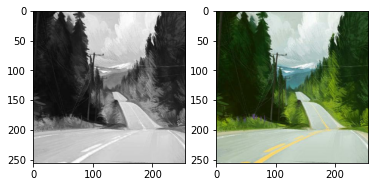

In [ ]:
for example_input, example_target in dataset.take(1):
    v = example_input
    hs = example_target


image, lightness = get_image(v, hs)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(lightness, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(image)

In [ ]:
dataset = dataset.shuffle(42)

In [ ]:
BATCH_SIZE = 1

In [ ]:
test_dataset = dataset.take(100).batch(BATCH_SIZE)
train_dataset = dataset.skip(100).batch(BATCH_SIZE)

In [ ]:
sns.distplot(np.array(tar))
# sns.distplot(np.array(prediction))

In [ ]:
generate_images(generator, load_thumb('./images/0001.jpeg')[tf.newaxis, ...], tar)

In [ ]:
generator.save('generator_1')

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model


input_shape = (512, 512, 3)
model = build_resnet50_unet(input_shape)
model.summary()

(512, 512, 3)

In [ ]:
input_shape = (512, 512, 3)
generator = build_resnet50_unet(input_shape)
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

ValueError: ignored